### LOAD LIBRAIRIES

In [1]:
import pandas as pd
import numpy as np

from sdv import load_demo
from sdv.tabular import GaussianCopula, CopulaGAN, CTGAN, TVAE
from sdv.demo import load_tabular_demo

import faker
#https://github.com/joke2k/faker

import seaborn as sb

from sklearnex import patch_sklearn
from sklearn import ensemble, tree, neighbors, linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, roc_auc_score
import xgboost

import warnings
warnings.filterwarnings("ignore")

### THE DATA

Kaggle :
- Titanic new version (https://www.kaggle.com/competitions/spaceship-titanic/)
- MINST (https://www.kaggle.com/competitions/digit-recognizer)
- Credit card fraud detection (https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud)
- Heart attack prediction (https://www.kaggle.com/datasets/rashikrahmanpritom/heart-attack-analysis-prediction-dataset)
- Red win quality (https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009)

In [4]:
path = "C:/Users/Valentin/OneDrive - RHAPSODIES/03 - CODE/XX DATA"

In [5]:
titanic = pd.read_csv(path+'/new_titanic_train.csv')

mnist = pd.read_csv(path+'/MNIST_train.csv')

heart = pd.read_csv(path+'/heart.csv')

credit_card = pd.read_csv(path+'/creditcard.csv')

wine = pd.read_csv(path+'/wine_red.csv')

datasets = [titanic, mnist, heart, credit_card, wine]

In [6]:
for dataset in datasets:
    print(dataset.shape)

(8693, 14)
(42000, 785)
(303, 14)
(284807, 31)
(1599, 12)


In [7]:
heart

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


In [8]:
titanic['Transported'] = titanic['Transported'].apply(lambda x: 1 if x == True else 0)
titanic = titanic.dropna()

In [9]:
wine['target'] = wine['quality'].apply(lambda x: 1 if x >= wine['quality'].mean() else 0)

### DEFINING FUNCTIONS

In [10]:
text_features = []
for column in titanic.columns:
    if titanic[column].dtype == 'object':
        text_features.append(column)

numeric_features = []
for column in titanic.columns:
    if titanic[column].dtype == 'float':
        numeric_features.append(column)

In [11]:
def get_synthetic(train_data):

    model = GaussianCopula()
    model.fit(train_data)

    synthetic_data = model.sample(train_data.shape[0])

    return synthetic_data

def synthetic_share(synthetic_data, real_data, share_rate):
    
    share_real = real_data.sample(int((1-share_rate)*real_data.shape[0]))
    share_synthetic = synthetic_data.sample(int(share_rate*synthetic_data.shape[0]))

    combined_data = pd.concat([share_real, share_synthetic], axis = 0)

    return combined_data

In [12]:
def train_evaluate_model(model, data, target):

    X_train, X_test, y_train, y_test = train_test_split(data.drop(target, axis = 1), data[target], random_state=42)
    model.fit(X_train, y_train)
    #print(classification_report(y_test, model.predict(X_test)))
    accuracy = accuracy_score(y_test, model.predict(X_test))
    precision = precision_score(y_test, model.predict(X_test))
    recall = recall_score(y_test, model.predict(X_test))
    roc_auc = roc_auc_score(y_test, model.predict(X_test))

    return accuracy, precision, recall, roc_auc

### MODEL TRAINING WITH GENERATED DATA

Let's practice : training 5 simple classification models on real data, mixed real / synthetic data and only synthetic data and assessing their performances.

In [13]:
results = pd.DataFrame(columns = ['share_rate', 'accuracy', 'precision', 'recall', 'roc_auc'])

s_data = get_synthetic(wine.drop('quality', axis = 1))

for rate in np.arange(0,1.01,0.01):

    combined_data = synthetic_share(s_data, wine.drop('quality', axis = 1), rate)

    accuracy, precision, recall, roc_auc = train_evaluate_model(ensemble.RandomForestClassifier(), combined_data, 'target')

    results = results.append(pd.Series([rate, accuracy, precision, recall, roc_auc],index = results.columns),ignore_index=True)

In [14]:
patch_sklearn()

results = pd.DataFrame(columns = ['share_rate', 'accuracy', 'precision', 'recall', 'roc_auc'])

s_data = get_synthetic(heart)

for rate in np.arange(0,1.01,0.01):

    combined_data = synthetic_share(s_data, heart, rate)

    accuracy, precision, recall, roc_auc = train_evaluate_model(ensemble.RandomForestClassifier(), combined_data, 'output')

    results = results.append(pd.Series([rate, accuracy, precision, recall, roc_auc],index = results.columns),ignore_index=True)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


<AxesSubplot:xlabel='share_rate', ylabel='roc_auc'>

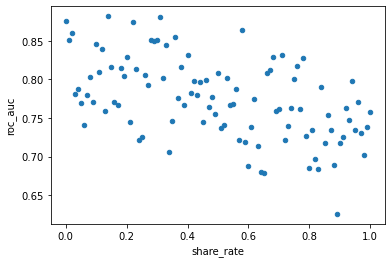

In [18]:
results.plot.scatter(x = 'share_rate', y = 'roc_auc')

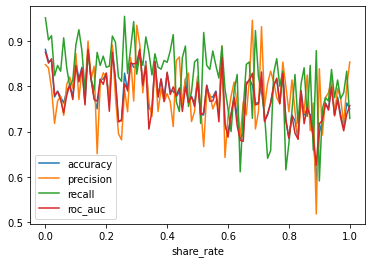

In [16]:
results.set_index('share_rate').plot();

### LOADING DEMO DATA AND MODELS

In [6]:
data = load_tabular_demo('student_placements')

display(data.head())
data.shape

,student_id,gender,second_perc,high_perc,high_spec,degree_perc,degree_type,work_experience,experience_years,employability_perc,mba_spec,mba_perc,salary,placed,start_date,end_date,duration
0,17264,M,67.00,91.00,Commerce,58.00,Sci&Tech,False,0,55.0,Mkt&HR,58.80,27000.0,True,2020-07-23,2020-10-12,3.0
1,17265,M,79.33,78.33,Science,77.48,Sci&Tech,True,1,86.5,Mkt&Fin,66.28,20000.0,True,2020-01-11,2020-04-09,3.0
2,17266,M,65.00,68.00,Arts,64.00,Comm&Mgmt,False,0,75.0,Mkt&Fin,57.80,25000.0,True,2020-01-26,2020-07-13,6.0
3,17267,M,56.00,52.00,Science,52.00,Sci&Tech,False,0,66.0,Mkt&HR,59.43,NaN,False,NaT,NaT,NaN
4,17268,M,85.80,73.60,Commerce,73.30,Comm&Mgmt,False,0,96.8,Mkt&Fin,55.50,42500.0,True,2020-07-04,2020-09-27,3.0


(215, 17)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   student_id          215 non-null    int64         
 1   gender              215 non-null    object        
 2   second_perc         215 non-null    float64       
 3   high_perc           215 non-null    float64       
 4   high_spec           215 non-null    object        
 5   degree_perc         215 non-null    float64       
 6   degree_type         215 non-null    object        
 7   work_experience     215 non-null    bool          
 8   experience_years    215 non-null    int64         
 9   employability_perc  215 non-null    float64       
 10  mba_spec            215 non-null    object        
 11  mba_perc            215 non-null    float64       
 12  salary              148 non-null    float64       
 13  placed              215 non-null    bool          

In [11]:
data.describe()

,student_id,second_perc,high_perc,degree_perc,experience_years,employability_perc,mba_perc,salary,duration
count,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,215.000000,148.000000,148.000000
mean,17371.000000,67.303395,66.333163,66.370186,0.390698,72.100558,62.278186,28865.540541,5.331081
std,62.209324,10.827205,10.897509,7.358743,0.584781,13.275956,5.833385,9345.745242,3.279266
min,17264.000000,40.890000,37.000000,50.000000,0.000000,50.000000,51.210000,20000.000000,3.000000
25%,17317.500000,60.600000,60.900000,61.000000,0.000000,60.000000,57.945000,24000.000000,3.000000
50%,17371.000000,67.000000,65.000000,66.000000,0.000000,71.000000,62.000000,26500.000000,3.000000
75%,17424.500000,75.700000,73.000000,72.000000,1.000000,83.500000,66.255000,30000.000000,6.000000
max,17478.000000,89.400000,97.700000,91.000000,3.000000,98.000000,77.890000,94000.000000,12.000000


Ajouter ici un tableau récap des modèles : nom, type de modèle, commentaires, lien vers le papier

In [9]:
model = GaussianCopula()
model.fit(data)

C:\Users\Valentin\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:5320: RuntimeWarning: divide by zero encountered in true_divide
  return c**2 / (c**2 - n**2)
C:\Users\Valentin\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2606: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
C:\Users\Valentin\anaconda3\lib\site-packages\scipy\stats\_continuous_distns.py:639: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
C:\Users\Valentin\anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\Valentin\anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warn

### GENERATING NEW DATA

In [12]:
new_data = model.sample(200)

In [14]:
new_data.describe()

,student_id,second_perc,high_perc,degree_perc,experience_years,employability_perc,mba_perc,salary,duration
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,135.000000,135.000000
mean,17375.070000,66.717100,65.450200,66.342950,0.495000,71.986750,61.843950,28831.111111,5.925926
std,64.286381,10.093587,10.484325,7.637506,0.593071,13.768636,5.383073,5073.320127,2.339249
min,17264.000000,44.890000,38.240000,50.000000,0.000000,50.180000,51.210000,20000.000000,3.000000
25%,17318.250000,59.165000,59.077500,60.275000,0.000000,59.925000,57.952500,25400.000000,4.000000
50%,17375.500000,66.380000,64.400000,66.065000,0.000000,71.925000,61.555000,28000.000000,6.000000
75%,17431.250000,75.152500,70.235000,72.270000,1.000000,83.062500,64.952500,31750.000000,8.000000
max,17477.000000,88.760000,97.700000,83.690000,3.000000,97.890000,77.890000,47500.000000,12.000000


In [16]:
## setting up primary key

# model = CTGAN(primary_key='student_id') 

# model.fit(data)

# new_data = model.sample(200)

# new_data.head()

### ADRESSING PERSONAL INFORMATION ISSUES

In [ ]:
data_pii = load_tabular_demo('student_placements_pii')
data_pii.head()

In [ ]:
In [21]: model = CTGAN(
   ....:     primary_key='student_id',
   ....: )
   ....: 

In [22]: model.fit(data_pii)

In [23]: new_data_pii = model.sample(200)

In [24]: new_data_pii.head()

new_data_pii.address.isin(data_pii.address).sum()
Out[25]: 200


In [26]: model = CTGAN(
   ....:     primary_key='student_id',
   ....:     anonymize_fields={
   ....:         'address': 'address'
   ....:     }
   ....: )
   ....: 

In [27]: model.fit(data_pii)

new_data_pii = model.sample(200)

In [29]: new_data_pii.head()

data_pii.address.isin(new_data_pii.address).sum()
Out[30]: 0


### ADVANCED MODEL TUNING

In [17]:
#on peut raconter ici tout ce qu'il est possible de faire avec le modèle : tuning des hyperparamètres, échantillonage conditionnel, contrainte des variables, ...

### EVALUATING GENERATED DATA
A very common question when someone starts using SDV to generate synthetic data is: “How good is the data that I just generated?”

In order to answer this question, SDV has a collection of metrics and tools that allow you to compare the real that you provided and the synthetic data that you generated using SDV or any other tool.

In the followin guides we will show you how to perform this evaluation and how to explore the different metrics that exist.

In [ ]:
In [9]: from sdv.evaluation import evaluate

In [10]: evaluate(synthetic_data, real_data)
Out[10]: 0.6250121152956873

In [ ]:
#comment on obtient ce score ?
evaluate(synthetic_data, real_data, aggregate=False)

Single Table Metric Families
The Single Table Metrics are grouped in multiple families:

Statistical Metrics: These are metrics that compare the tables by running different statistical tests on them. Some of them work by comparing multiple columns at once, while other compare the different individual columns separately and later on return an aggregated result.

Likelihood Metrics: These metrics attempt to fit a probabilistic model to the real data and later on evaluate the likelihood of the synthetic data on it.

Detection Metrics: These metrics try to train a Machine Learning Classifier that learns to distinguish the real data from the synthetic data, and report a score of how successful this classifier is.

Machine Learning Efficacy Metrics: These metrics train a Machine Learning model on your synthetic data and later on evaluate the model performance on the real data. Since these metrics need to evaluate the performance of a Machine Learning model on the dataset, they work only on datasets that represent a Machine Learning problem.

Privacy Metrics: These metrics fit an adversial attacker model on the synthetic data and then evaluate its accuracy (or probability of making the correct attack) on the real data.


In [19]:
#on fait un deep dive sur 2 métrics qui nous intéressent : ML et Privacy